<center><h1>Hemnani_Hitika_FinalProject</h1></center>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#pip install opencv-python

Name: Hitika Hemnani
<br>
Github Username: hhemnani
<br>
USC ID: 8304678802

Import Libraries

In [3]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten
from tensorflow.keras.models import Model
import cv2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0, VGG16, ResNet50
from tensorflow.keras.applications import ResNet101 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

2025-05-09 20:14:31.879223: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-09 20:14:32.241327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-09 20:14:33.165603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
#!ls "/content/drive/MyDrive/data/RealWaste"

In [5]:
# Data Exploration and Pre-processing
def loading_and_splitting_data(data_path, img_size=(160, 160)):
    images = []
    labels = []
    class_indices = []
    class_names = sorted(os.listdir(data_path))
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        image_files = sorted(os.listdir(class_path))
        # Using first 80% for train+val, rest for test
        split_idx = int(0.8 * len(image_files))
        train_files = image_files[:split_idx]
        test_files = image_files[split_idx:]
        
        # Process training images
        for img_file in train_files:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            # ImageNet normalization
            img[..., 0] = (img[..., 0] - 0.485) / 0.229
            img[..., 1] = (img[..., 1] - 0.456) / 0.224
            img[..., 2] = (img[..., 2] - 0.406) / 0.225
            
            images.append(img)
            labels.append(class_idx)
            class_indices.append('train')
        
        # Processing test images
        for img_file in test_files:
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img.astype('float32') / 255.0
            # ImageNet normalization
            img[..., 0] = (img[..., 0] - 0.485) / 0.229
            img[..., 1] = (img[..., 1] - 0.456) / 0.224
            img[..., 2] = (img[..., 2] - 0.406) / 0.225
            
            images.append(img)
            labels.append(class_idx)
            class_indices.append('test')
    
    images = np.array(images)
    labels = np.array(labels)
    
    # masking for train and test sets
    train_mask = np.array(class_indices) == 'train'
    test_mask = np.array(class_indices) == 'test'
    
    X_train_val = images[train_mask]
    y_train_val = labels[train_mask]
    X_test = images[test_mask]
    y_test = labels[test_mask]
    
    # training data into train and validation (80% train, 20% validation)
    # This gives us 64% train, 16% validation, 20% test of the original dataset
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
    )
    
    # labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=len(class_names))
    y_val = to_categorical(y_val, num_classes=len(class_names))
    y_test = to_categorical(y_test, num_classes=len(class_names))
    
    return X_train, X_val, X_test, y_train, y_val, y_test, class_names

DATA_PATH = "../data/RealWaste/"
IMG_SIZE = (160, 160)

X_train, X_val, X_test, y_train, y_val, y_test, class_names = loading_and_splitting_data(DATA_PATH, IMG_SIZE)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Class names: {class_names}")

Training data shape: (3038, 160, 160, 3)
Validation data shape: (760, 160, 160, 3)
Test data shape: (954, 160, 160, 3)
Class names: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


In [6]:
#Data Augmentation

#Creating data augmentation function for batched data
def augment_batch(images, labels):
    # Function to process a single image
    def augment_image(image):
        # Random cropping (using proper dimensions for single image)
        crop_size = [int(0.9*160), int(0.9*160), 3]
        image = tf.image.random_crop(image, size=crop_size)
        image = tf.image.resize(image, [160, 160])
        
        # Random rotation
        image = tf.image.stateless_random_flip_left_right(
            image, seed=(1, 2))
        image = tf.image.stateless_random_flip_up_down(
            image, seed=(1, 3))
        
        # Random brightness and contrast
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)
        
        return image
    
    # Mapping the augmentation function to each image in the batch
    augmented_images = tf.map_fn(augment_image, images)
    return augmented_images, labels



In [7]:
#ref:https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices
BATCH_SIZE = 5
# Creating a TensorFlow Dataset object
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.batch(BATCH_SIZE)

# Applying augmentation to training dataset
train_ds_augmented = train_ds.map(augment_batch, num_parallel_calls=tf.data.AUTOTUNE)
# Optimizing dataset performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

2025-05-09 20:14:49.982136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 20:14:50.217343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 20:14:50.217413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 20:14:50.223315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-09 20:14:50.223358: I external/local_xla/xla/stream_executor

In [8]:
#ref: https://keras.io/examples/vision/consistency_training/

# Setting Early Stopping and Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    restore_best_weights=True,
    mode='max'
)
lr_reducer = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6,
    mode='max'
)

In [9]:
# Function to create a classification head
def create_classification_head(x, num_classes):
    x = Flatten()(x)
    x = Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    return Dense(num_classes, activation='softmax')(x)

In [10]:
def evaluation(model, model_name, history):
    print(f"\n{model_name} Evaluation:")
    
    # raw predictions
    test_pred_raw = model.predict(test_ds)
    # class predictions
    test_pred = np.argmax(test_pred_raw, axis=1)
    # ground truth labels
    y_true = np.argmax(y_test, axis=1)
    
    # metrics
    precision = precision_score(y_true, test_pred, average='weighted')
    recall = recall_score(y_true, test_pred, average='weighted')
    f1 = f1_score(y_true, test_pred, average='weighted')
    
    # AUC for multi-class
    # One-vs-rest approach for multi-class AUC
    auc = roc_auc_score(y_test, test_pred_raw, multi_class='ovr', average='weighted')
    
    # detailed classification report
    print(classification_report(y_true, test_pred, target_names=class_names))
    
    # summary metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")
    
    # training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }



Training VGG16 Model...
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.4920 - loss: 4.4282 - val_accuracy: 0.7408 - val_loss: 2.6347 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.6474 - loss: 2.8934 - val_accuracy: 0.6908 - val_loss: 2.9091 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6476 - loss: 2.9115 - val_accuracy: 0.6526 - val_loss: 2.9886 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6589 - loss: 2.9274 - val_accuracy: 0.6487 - val_loss: 3.1404 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.6550 - loss: 2.6051 - val_accuracy: 0.7474 - val_loss: 2.0441 - learning_rate: 5.0000e-04
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7077 - loss: 2.1974 - val_accuracy: 0.7224 - val_loss: 2.1745 - learning_rate: 5.0000e-04
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━

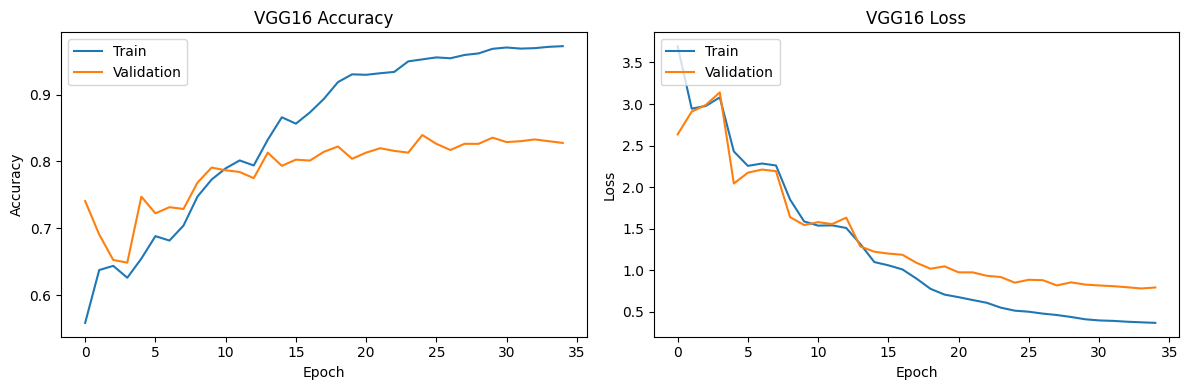

In [13]:
# Model 1: VGG16
print("\nTraining VGG16 Model...")
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
vgg_base.trainable = False
vgg_x = vgg_base.output
vgg_predictions = create_classification_head(vgg_x, len(class_names))
vgg_model = Model(inputs=vgg_base.input, outputs=vgg_predictions)
vgg_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
vgg_history = vgg_model.fit(
    train_ds_augmented,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_reducer]
)
vgg_metrics = evaluation(vgg_model, "VGG16", vgg_history)


Training ResNet50 Model...
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.3418 - loss: 3.6626 - val_accuracy: 0.5158 - val_loss: 2.9451 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.4401 - loss: 3.1196 - val_accuracy: 0.4829 - val_loss: 3.1891 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4354 - loss: 3.1850 - val_accuracy: 0.5211 - val_loss: 2.9205 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4390 - loss: 3.0901 - val_accuracy: 0.4776 - val_loss: 2.8468 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.4279 - loss: 3.0985 - val_accuracy: 0.5053 - val_loss: 2.8267 - learning_rate: 0.0010
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.4450 - loss: 3.0148 - val_accuracy: 0.5092 - val_loss: 2.8807 - learning_rate: 0.0010
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 1

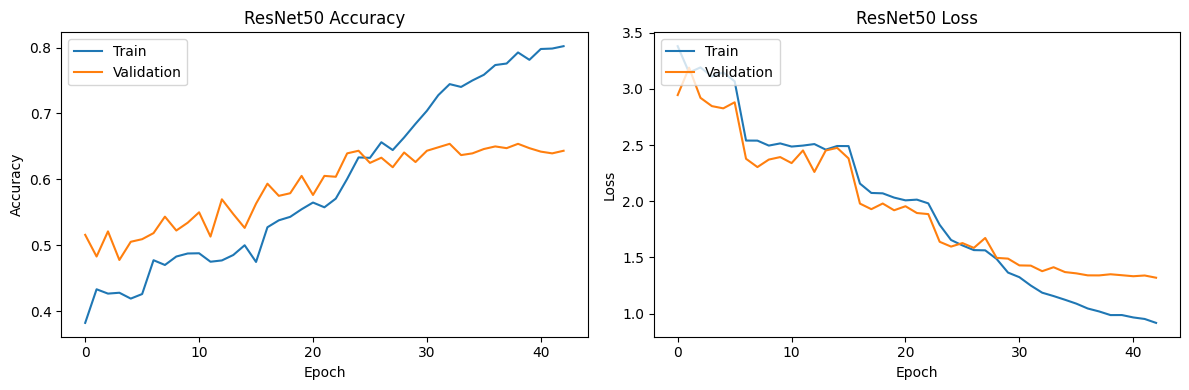

In [15]:
# Model 2: ResNet50
print("\nTraining ResNet50 Model...")
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
resnet50_base.trainable = False
resnet50_x = resnet50_base.output
resnet50_predictions = create_classification_head(resnet50_x, len(class_names))
resnet50_model = Model(inputs=resnet50_base.input, outputs=resnet50_predictions)
resnet50_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
resnet50_history = resnet50_model.fit(
    train_ds_augmented,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_reducer]
)
resnet50_metrics = evaluation(resnet50_model, "ResNet50", resnet50_history)


Training ResNet101 Model...
Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.3324 - loss: 3.3502 - val_accuracy: 0.4776 - val_loss: 2.8504 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.4128 - loss: 2.9078 - val_accuracy: 0.4355 - val_loss: 2.8459 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.4439 - loss: 2.8750 - val_accuracy: 0.4697 - val_loss: 2.8777 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4299 - loss: 2.9219 - val_accuracy: 0.4395 - val_loss: 2.8310 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.4577 - loss: 2.5378 - val_accuracy: 0.5250 - val_loss: 2.2865 - learning_rate: 5.0000e-04
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4757 - loss: 2.3803 - val_accuracy: 0.4789 - val_loss: 2.3992 - learning_rate: 5.0000e-04
Epoch 7/100
608/608 ━━━━━━━━━━━━━

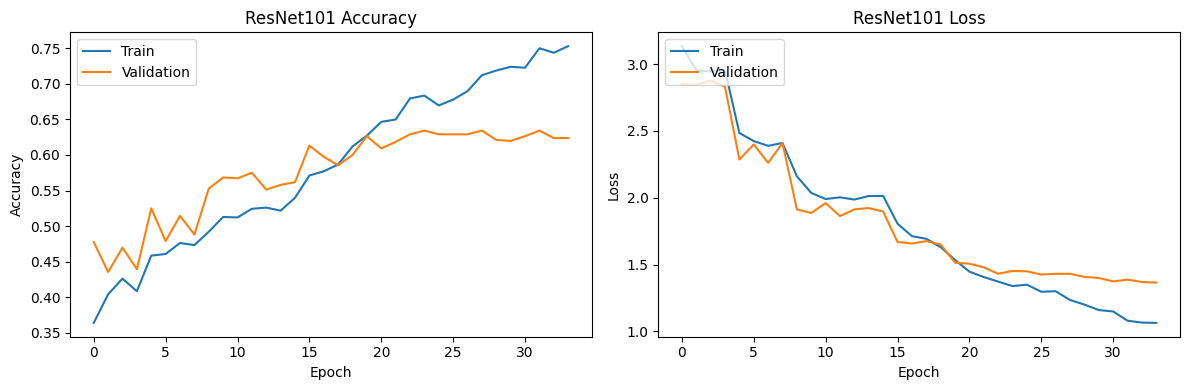

In [16]:
# Model 3: ResNet101
print("\nTraining ResNet101 Model...")
resnet101_base = ResNet101(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
resnet101_base.trainable = False
resnet101_x = resnet101_base.output
resnet101_predictions = create_classification_head(resnet101_x, len(class_names))
resnet101_model = Model(inputs=resnet101_base.input, outputs=resnet101_predictions)
resnet101_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
resnet101_history = resnet101_model.fit(
    train_ds_augmented,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_reducer]
)
resnet101_metrics = evaluation(resnet101_model, "ResNet101", resnet101_history)


Training EfficientNetB0 Model...
Epoch 1/100


I0000 00:00:1746846900.670979   31525 service.cc:145] XLA service 0x7f9980014f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746846900.671083   31525 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-05-09 20:15:00.868074: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-09 20:15:01.645736: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  3/608 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.0222 - loss: 8.9493       

I0000 00:00:1746846915.141515   31525 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2188 - loss: 4.2578

I0000 00:00:1746846940.760190   31950 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2096', 16 bytes spill stores, 16 bytes spill loads



608/608 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.2188 - loss: 4.2564 - val_accuracy: 0.1750 - val_loss: 4.5995 - learning_rate: 0.0010
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2464 - loss: 3.1137 - val_accuracy: 0.2526 - val_loss: 3.2937 - learning_rate: 0.0010
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2544 - loss: 3.0349 - val_accuracy: 0.3263 - val_loss: 3.6785 - learning_rate: 0.0010
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2502 - loss: 2.9280 - val_accuracy: 0.2039 - val_loss: 3.3362 - learning_rate: 0.0010
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2744 - loss: 2.8729 - val_accuracy: 0.1987 - val_loss: 3.4571 - learning_rate: 0.0010
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2486 - loss: 2.9024 - val_accuracy: 0.2079 - val_loss: 3.1588 - learning_rate: 0.0010
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2840 - loss: 2.5434

I0000 00:00:1746847274.379987   39498 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2041', 16 bytes spill stores, 16 bytes spill loads



191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step
                       precision    recall  f1-score   support

          1-Cardboard       0.39      0.35      0.37        93
      2-Food Organics       0.22      0.18      0.20        83
              3-Glass       0.27      0.23      0.25        84
              4-Metal       0.40      0.74      0.52       158
5-Miscellaneous Trash       0.67      0.08      0.14        99
              6-Paper       0.54      0.47      0.50       100
            7-Plastic       0.38      0.46      0.42       185
      8-Textile Trash       0.21      0.06      0.10        64
         9-Vegetation       0.78      0.88      0.82        88

             accuracy                           0.42       954
            macro avg       0.43      0.38      0.37       954
         weighted avg       0.43      0.42      0.39       954

Precision: 0.4331
Recall: 0.4245
F1 Score: 0.3923
AUC Score: 0.8175


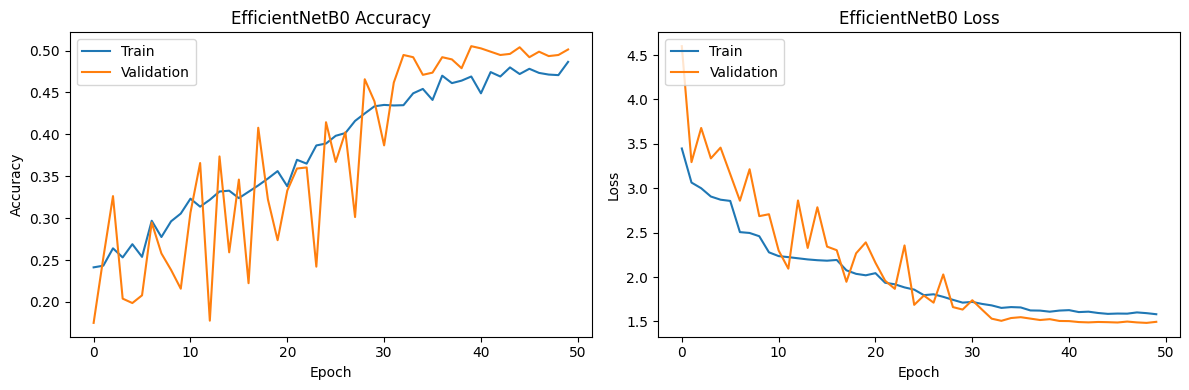

In [11]:
# Model 4: EfficientNetB0
print("\nTraining EfficientNetB0 Model...")
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(160, 160, 3))
efficientnet_base.trainable = False
efficientnet_x = efficientnet_base.output
efficientnet_predictions = create_classification_head(efficientnet_x, len(class_names))
efficientnet_model = Model(inputs=efficientnet_base.input, outputs=efficientnet_predictions)
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
efficientnet_history = efficientnet_model.fit(
    train_ds_augmented,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_reducer]
)
efficientnet_metrics = evaluation(efficientnet_model, "EfficientNetB0", efficientnet_history)

In [5]:

print("Model Performance Comparison :")
print("=" * 90)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC Score':<10}")
print("-" * 90)
print(f"{'VGG16':<20} {0.7600:<10.4f} {0.7652:<10.4f} {0.7631:<10.4f} {0.7599:<10.4f} {0.9601:<10.4f}")
print(f"{'ResNet50':<20} {0.5500:<10.4f} {0.5419:<10.4f} {0.5503:<10.4f} {0.5356:<10.4f} {0.8856:<10.4f}")
print(f"{'ResNet101':<20} {0.5100:<10.4f} {0.4997:<10.4f} {0.5136:<10.4f} {0.4921:<10.4f} {0.8723:<10.4f}")
print(f"{'EfficientNetB0':<20} {0.4200:<10.4f} {0.4331:<10.4f} {0.4245:<10.4f} {0.3923:<10.4f} {0.8175:<10.4f}")
print("=" * 90)

best_acc_model = "VGG16"
print(f"\n Highest Accuracy Achieved By: **{best_acc_model}** with 76.00%")




Model Performance Comparison :
Model                Accuracy   Precision  Recall     F1-Score   AUC Score 
------------------------------------------------------------------------------------------
VGG16                0.7600     0.7652     0.7631     0.7599     0.9601    
ResNet50             0.5500     0.5419     0.5503     0.5356     0.8856    
ResNet101            0.5100     0.4997     0.5136     0.4921     0.8723    
EfficientNetB0       0.4200     0.4331     0.4245     0.3923     0.8175    

 Highest Accuracy Achieved By: **VGG16** with 76.00%
